# Recent rainfall data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

N_DAYS_MAX = 29

We get the recent rainfall data from the UK defra website, see https://environment.data.gov.uk/flood-monitoring/doc/rainfall. We first load and parse the JSON data into a pandas DataFrame.

In [2]:
def load_data(station_ID, N_days=N_DAYS_MAX):
    url = build_url(station_ID, N_days)
    
    response = json.loads(requests.get(url).text)
    data = pd.DataFrame(response['items'])
    if not data.empty:
        datetimes = data['dateTime']
        data.drop(columns = ['@id','measure','dateTime'], inplace=True)
        data.set_index(pd.to_datetime(datetimes), inplace=True)
    return data

def build_url(station_ID, N_days=N_DAYS_MAX):
    if N_days > N_DAYS_MAX:
        N_days = N_DAYS_MAX
        
    data_url = "https://environment.data.gov.uk/flood-monitoring/id/stations/"
    
    today = pd.Timestamp.today()
    start = (today - pd.Timedelta(days=N_days)).strftime('%Y-%m-%d')
    today  = today.strftime('%Y-%m-%d')
    
    url_param = "/readings.json?startdate=" + start + "&enddate=" + today + "&_sorted&parameter=rainfall&_limit=10000"
    url = data_url + station_ID + url_param
    return url

In [3]:
from matplotlib.dates import DayLocator, DateFormatter

def rainfall_plot(data, average = False):
    fig, ax = plt.subplots()
    
    if average:
        data_mean = data.mean(axis=1)
        ymin = data_mean - data.min(axis=1)
        ymax = data.max(axis=1) - data_mean
        data_mean.plot(ax=ax,yerr= (ymin,ymax),marker='o', capsize=3, ecolor='r')
        ax.set_title('Average Daily Rainfall')
    else:
        data.plot(ax=ax)
        ax.set_title('Daily Rainfall')
    
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.xaxis.set_major_locator(DayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%b-%d"))
    ax.tick_params(axis="x", labelrotation= 90, bottom=True,labelbottom=True)

    
    ax.set_ylabel('Rainfall (mm)')
    ax.set_xlabel('Day')
    return (fig, ax)

Now that we have all the tools, let's load an plot the data

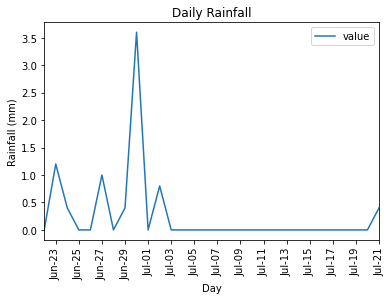

In [4]:
N_days = 29
station_ID = "245176TP"

data = load_data(station_ID,N_days)
data_daily = data.resample('1D').sum()
data_daily.index = pd.to_datetime(data_daily.index.date)
_ = rainfall_plot(data_daily)


## Multiple Stations

Now let's make things more interesting and use data from multiple stations.

In [5]:
def load_multiple(station_IDs, N_days=N_DAYS_MAX):
    
    # Make empty dataframe with date index
    dates = pd.date_range(pd.Timestamp.today().floor('d'), periods=N_DAYS_MAX+1, freq="-1D")
    data = pd.DataFrame(index=pd.to_datetime(dates)).sort_index()
    
    # Loop over stations
    for ID in station_IDs:
        data_single = load_data(ID,N_days)
        
        if data_single.empty:
            # Return a NaN DataFrame
            data_daily = pd.DataFrame(np.nan, columns=['value'],index=pd.to_datetime(dates)).sort_index()
        else:
            data_daily = data_single.resample('1D').sum()
            data_daily.index = pd.to_datetime(data_daily.index.date)
            
        data[ID] = data_daily
        
    return data

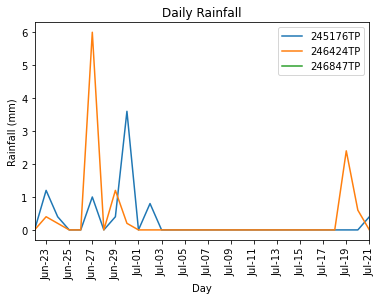

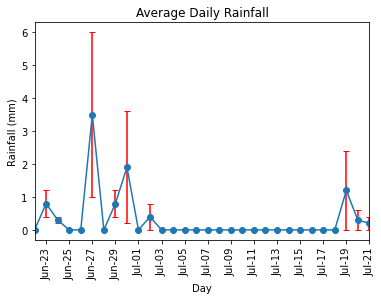

In [6]:
datas = load_multiple([station_ID,'246424TP','246847TP'],N_days)
_=rainfall_plot(datas)
_=rainfall_plot(datas,average=True)

## Using postcode to find nearby stations

In [7]:
def postcode_valid(postcode):
    # Uses https://api.postcodes.io/ 
    # Only process English postcodes because the rainfall API only has English data
    
    url = "https://api.postcodes.io/postcodes/"+postcode
    response = json.loads(requests.get(url).text)
    return response['status']==200 and response['result']['country']=='England'

def postcode_lookup(postcode):
    # Uses https://api.postcodes.io/ 
    
    url = "https://api.postcodes.io/postcodes/"+postcode
    response = json.loads(requests.get(url).text)
      
    if postcode_valid(postcode):
        latlong = (response['result']['longitude'],response['result']['latitude'])
    else:
        latlong = ()
        
    return latlong

In [8]:
def find_stations(latlong,names_only=True,dist=10):
    if isinstance(latlong, tuple) and len(latlong)==2:
    
        lat = str(latlong[1])
        long = str(latlong[0])
        dist = str(dist)

        data_url = "https://environment.data.gov.uk/flood-monitoring/id/stations"
        url_param = "?parameter=rainfall&lat="+ lat + "&long="+ long+ "&dist="

        url = data_url + url_param + dist

        response = json.loads(requests.get(url).text)
        data = pd.DataFrame(response['items'])
        if names_only:
            return data['notation']
        else:
            return data
    else:
        raise Exception("Invalid latitude and longitude format")
    

In [9]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import plotly.express as px

def show_stations(stations, plotter='plotly',show=True):
    (extent,zoom_level) = find_mapsize(stations)
    
    if plotter=='plotly':
        fig = px.scatter_mapbox(stations, lat="lat", lon="long", hover_name="notation",
                                color_discrete_sequence=["red"], zoom=zoom_level-1, width = 600, height =600)
        fig.update_layout(mapbox_style="open-street-map")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        if show:
            fig.show()
        return fig
    else:
        tiler = OSM()
        mercator = tiler.crs

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection=mercator)
        
        ax.set_extent(extent, crs=ccrs.PlateCarree())

        ax.add_image(tiler, zoom_level)

        ax.plot(stations['long'],stations['lat'], 'ro',transform=ccrs.PlateCarree())
        if not show:
            plt.close()
        return (fig,ax)         
    
def find_mapsize(stations, edge_factor = 0.5):
    long_size = stations['long'].max()-stations['long'].min()
    lat_size = stations['lat'].max()-stations['lat'].min()
    
    extent = [stations['long'].min() - edge_factor*long_size,
              stations['long'].max() + edge_factor*long_size,
              stations['lat'].min() - edge_factor*lat_size,
              stations['lat'].max() + edge_factor*lat_size]
    
    # OSM zoom level = log2(360/long_size)   
    zoom_level = int(np.floor(np.log2(360/max(long_size,lat_size))))
    
    return (extent,zoom_level)

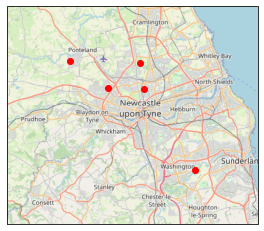

In [10]:
latlong = postcode_lookup('NE46AL')
stations = find_stations(latlong,names_only=False, dist=10)
fig = show_stations(stations,plotter='henk',show=True)
#ax.plot(latlong[0],latlong[1],'bo',transform=ccrs.PlateCarree())

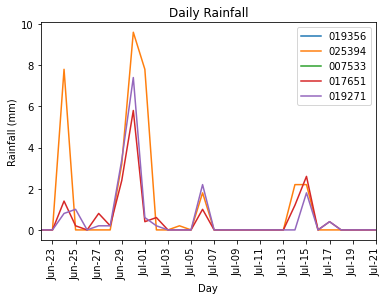

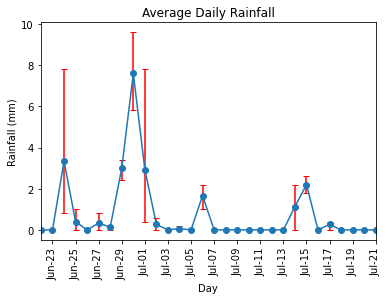

In [11]:
data = load_multiple(stations['notation'],N_days)
(fig2,_)=rainfall_plot(data)
(fig3,_)=rainfall_plot(data,average=True)

## Making a Dash dashboard

In [12]:
from dash import Dash, dcc, html, Input, Output
from dash.exceptions import PreventUpdate
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc

app = JupyterDash(external_stylesheets=[dbc.themes.BOOTSTRAP])

row = html.Div(
    [
        dbc.Row(
            dbc.Input(id="input", placeholder="SW1A2AB", type="text", value="SW1A2AB", debounce=True)
        ),
        html.Br(),
        dbc.Row(
            html.Div(id='text_output')
        ),
        html.Br(),
        dbc.Row(
            [
                dbc.Col(html.Div(dcc.Graph(id= 'map'))),
                dbc.Col(
                    [
                    html.Div(dcc.Graph(figure=mpl_to_plotly(fig2))),
                    html.Div(dcc.Graph(figure=mpl_to_plotly(fig2)))
                    ]
                ),
            ],id='figures',
        ),
    ]
)
app.layout = dbc.Container(row)

@app.callback(
    Output('text_output', 'children'),
    Input('input', 'value'))
def callback_text(postcode):
    if postcode_valid(postcode):
        return f'Looking at postcode {postcode}'
    else:
        return f'{postcode} is not a valid postcode within England'

@app.callback(
    Output('map', 'figure'),
    Input('input', 'value'))
def callback_map(postcode):
    latlong = postcode_lookup(postcode)
    if latlong:
        stations = find_stations(latlong,names_only=False, dist=10)
        fig = show_stations(stations,show=False)
    else:
        raise PreventUpdate
    return fig


_=app.run_server(mode='jupyterlab')

NameError: name 'mpl_to_plotly' is not defined

## Triangulation to figure out optimal averaging between nearest stations

TBD